In [ ]:
!pip install yfinance --quiet
!pip install yahooquery --quiet
!pip install requests_html --quiet
!pip install ydata_profiling --quiet
!pip install PyPortfolioOpt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.4 MB/s et

In [ ]:
# Modules imports
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import yfinance as yf
from yahooquery import Screener
import requests
from requests_html import HTMLSession
from datetime import datetime
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting as pt

# The goal
Inspired by the G-Reseach competition in [Kaggle](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview) and [this portfolio optimizer tool](https://www.portfoliovisualizer.com/optimize-portfolio)

Our aim is to create a Streamlit App to generate, for a given:
  - Porfolio of crypto-currencies.
  - Budget.

The optimized ratio of chosen currencies by maximizing the Sharpe Ratio

We begin the exercice with a step by step guided notebook to cover all the inner working of task completion before wrapping everything in **App.py** script.

# The Data

We'll start with a selection of 5 most popular crypto currencies by market capitalization.

## Getting Data

For scraping historical trading data of the crypto currencies, we rely on Yahoo! finance API.
Fortunatly there is a python [project](https://pypi.org/project/yfinance/) who offers an easy pythonic way to get data.

In [ ]:
# Scraping list of 5 most popular crypto tickets (cc)

session = HTMLSession()
num_currencies=5
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
cc = df.Symbol.tolist()
cc

['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD']

In [ ]:
# For the given cryptocurrencies, we grab the daily histrical closing price data since 2020:

tickers = yf.Tickers(cc)
end_date = datetime.now().strftime('%Y-%m-%d')
data = tickers.history(start='2020-01-01',end=end_date,interval='1d')['Close']
data

[*********************100%***********************]  5 of 5 completed


,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-01-01,13.689083,7200.174316,130.802002,1.004079,0.999836
2020-01-02,13.027011,6985.470215,127.410179,1.005017,1.001565
2020-01-03,13.660452,7344.884277,134.171707,1.005273,1.004192
2020-01-04,13.891512,7410.656738,135.069366,1.009466,1.007472
2020-01-05,14.111019,7411.317383,136.276779,1.008497,1.006197
...,...,...,...,...,...
2023-04-26,330.821777,28422.701172,1866.564209,0.999884,1.000282
2023-04-27,331.195099,29473.787109,1908.786377,0.999682,0.999965
2023-04-28,324.500244,29340.261719,1892.512817,0.999895,1.000696


## Preprocessing Data

In [ ]:
# missing data
data.isna().sum()

BNB-USD     0
BTC-USD     0
ETH-USD     0
USDC-USD    0
USDT-USD    0
dtype: int64

In [ ]:
data.dtypes

BNB-USD     float64
BTC-USD     float64
ETH-USD     float64
USDC-USD    float64
USDT-USD    float64
dtype: object

In [ ]:
#data = data.dropna()

In [ ]:
#data.isna().sum()

Other than missing values, it seems there is no issues with observations to handle, we save the downloaded data as a csv file for future exploitation.

# EDA

Having no issues with data, the next step is to explore their main statistical features.

In [ ]:
data.describe()

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,247.790487,28453.869506,1687.884086,1.000640,1.000588
std,181.198977,16348.745521,1209.184810,0.004092,0.002549
min,9.386050,4970.788086,110.605873,0.970124,0.974248
25%,28.530397,13628.286377,432.399002,0.999887,1.000022
50%,284.337418,23651.378906,1586.356079,1.000062,1.000261
75%,371.710228,41559.517578,2560.135254,1.000330,1.000797
max,675.684082,67566.828125,4812.087402,1.044029,1.053585


And distributions.

[Text(0.5, 0, 'Tickers'), Text(0, 0.5, 'Closing Price in USD')]

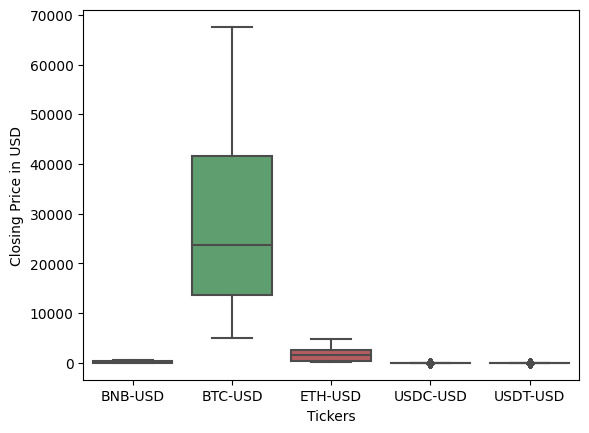

In [ ]:
sns.boxplot(data).set(xlabel='Tickers', 
                      ylabel='Closing Price in USD')

Switching to logaritimic scale for more visibility.

[Text(0.5, 0, 'Tickers'), Text(0, 0.5, 'Closing Price in USD')]

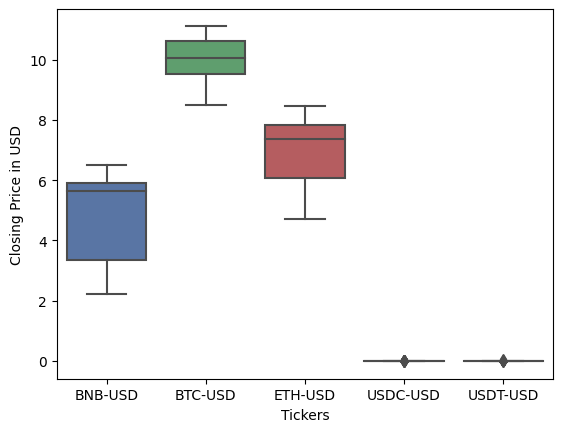

In [ ]:
log_data = np.log(data)
sns.boxplot(log_data).set(xlabel='Tickers', 
                          ylabel='Closing Price in USD')

It seems we have two groups of currencices.

But before jumping to conclusions, let's inspect the relation between each two currencies.

## Correlation Analysis

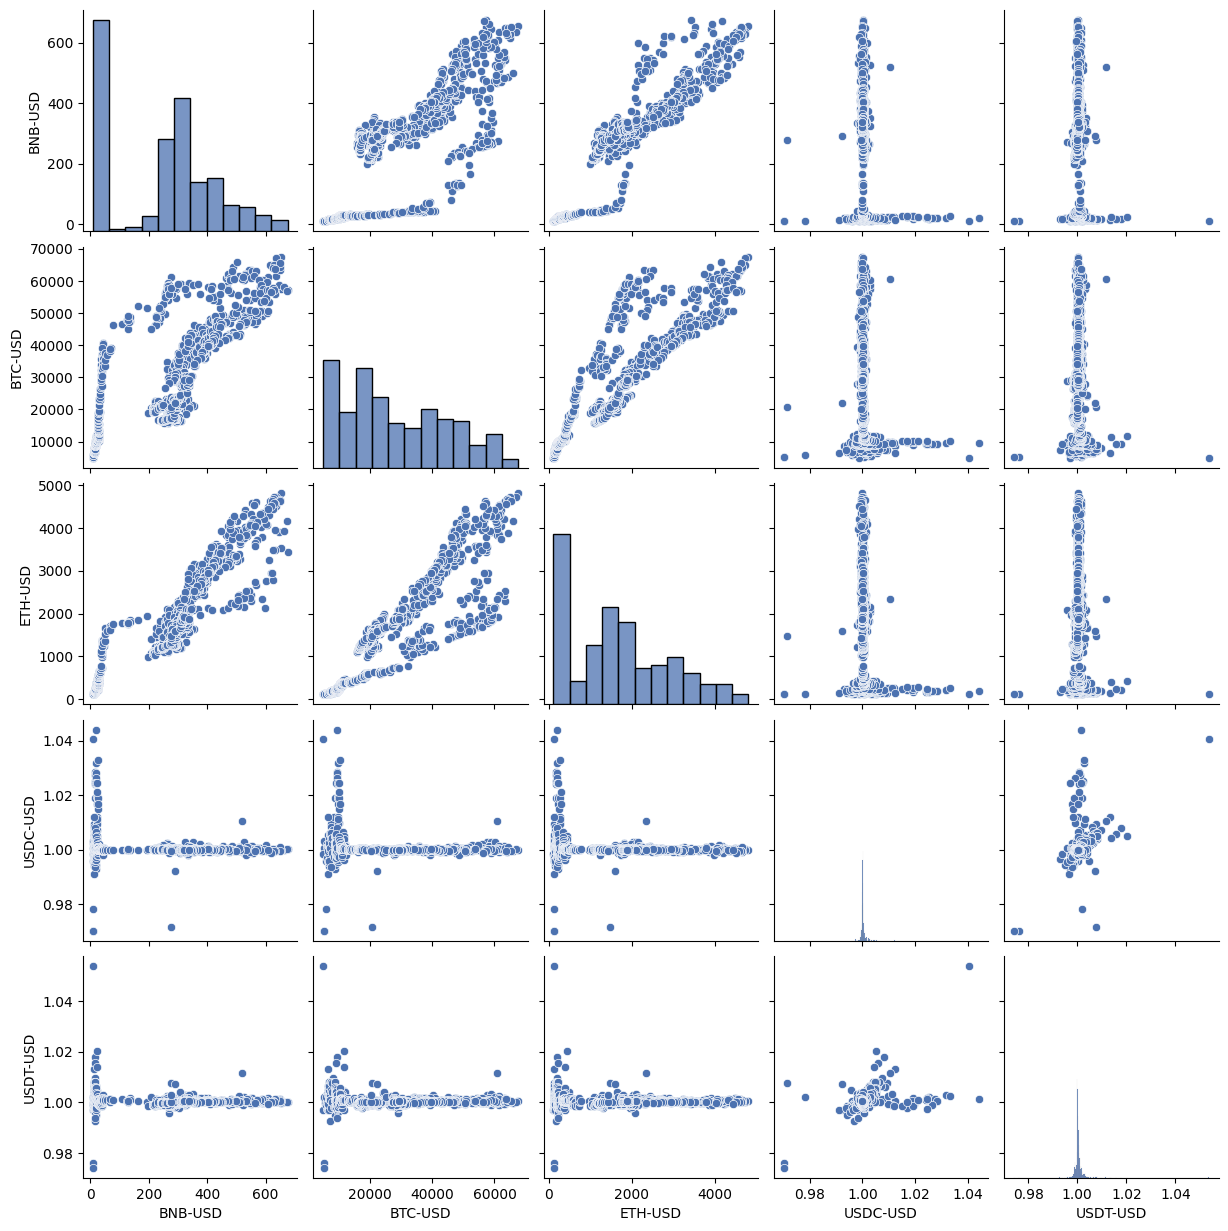

In [ ]:
# Ploting each two currencies at a time
sns.pairplot(data)

Text(0.5, 1.0, 'Correlation Heatmap')

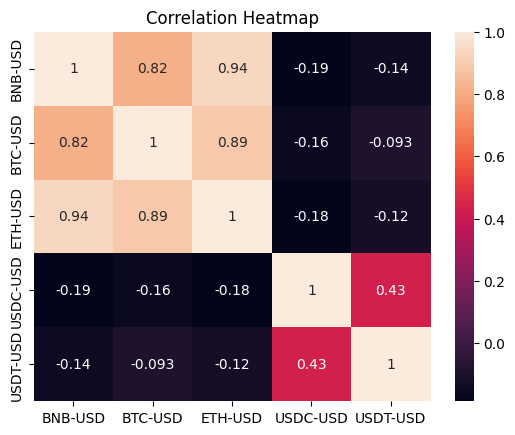

In [ ]:
# Calculating and visualizing the correlation between each two currency
corr = data.corr()
sns.heatmap(corr, annot=True).set_title('Correlation Heatmap')

Indeed, two groups of hight and low correlated currencies.

## Volatility Analysis

In finance, mesuring volatilty is assessing how much of a fluctuating an asset is, and the more an asset is volatile, the riskier it is and more difficult to predict.

In [ ]:
df = data.copy()

In [ ]:
df = np.log(df/df.shift()).rolling(window=365).std()*365**.5

Unlike stock markets where we do specify 252 days of trading per year.

Crypto markets are 24/7 traded throughtout the year.

The choice of 365 days of rolling window is to calculate the annualized volatility.

In [ ]:
df = df.dropna()

In [ ]:
df

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-12-31,0.974188,0.766632,1.001485,0.106998,0.106501
2021-01-01,0.972838,0.765921,1.001114,0.106994,0.106495
2021-01-02,0.971830,0.769314,1.001467,0.106994,0.106470
2021-01-03,0.974283,0.769468,1.026627,0.106913,0.106420
2021-01-04,0.974236,0.770008,1.028306,0.106909,0.106413
...,...,...,...,...,...
2023-04-26,0.678295,0.612391,0.823971,0.036260,0.008794
2023-04-27,0.678112,0.612789,0.823780,0.036260,0.008799
2023-04-28,0.677290,0.612633,0.823623,0.036260,0.008829


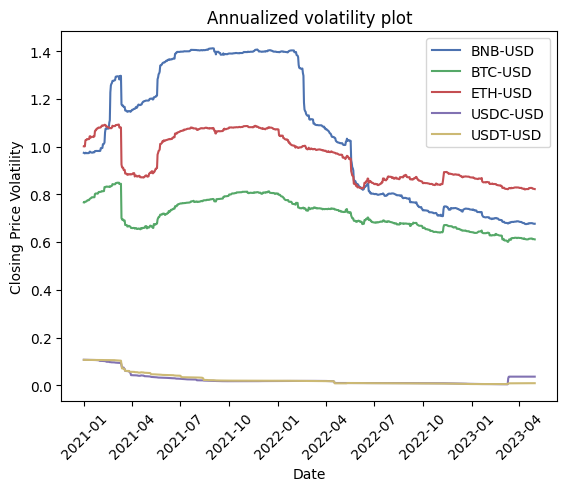

In [ ]:
#Visualizing the Annulized volatility
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Closing Price Volatility')
plt.title('Annualized volatility plot')
plt.legend(df.columns.values)
plt.xticks(rotation=45)
plt.show()

We Can identify two groups of correlated currencies:


*   Hight Volatility/Positive correlated currencies consisted of:
    1.   BitCoin (BTC)
    2.   Etherium (ETH)
    3.   Binance Coin (BNB)


*   Low Volatility/Negative correlated set of:
    1.   USD Coin (USDC)
    2.   Tether (USDT)


# Modeling
For the modeling section, we rely on Mean-variance optimization (MVO) solution provided by PyPortfolioOpt Library.

The MVO solution is constrained by maximizing the Sharpe ratio which is reputable to indicate how well the risk-ajusted performance a portfolio can be.

The higher the ratio (preferably above 1) the better investment decision is.





In [ ]:
# Calculating the mean historical return and covariance matrices
mu = mean_historical_return(data)
S = CovarianceShrinkage(data).ledoit_wolf()

In [ ]:
mu

BNB-USD     0.944147
BTC-USD     0.337593
ETH-USD     0.737543
USDC-USD   -0.000845
USDT-USD    0.000125
dtype: float64

In [ ]:
S

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
BNB-USD,0.743425,0.335402,0.452980,-0.002973,-0.005654
BTC-USD,0.335402,0.345285,0.366112,-0.002292,-0.004716
ETH-USD,0.452980,0.366112,0.593210,-0.003622,-0.006356
USDC-USD,-0.002973,-0.002292,-0.003622,0.010081,0.001859
USDT-USD,-0.005654,-0.004716,-0.006356,0.001859,0.009812


The risk free market is corresponding to the US Federal Reserve Interest Rate (its a choice)

In [ ]:
# Scrapping the current FED interest rate:
all_data = pd.read_html('https://www.global-rates.com/en/interest-rates/central-banks/central-bank-america/fed-interest-rate.aspx')
FED = [df for df in all_data if df.iloc[0][0] == 'American interest rate (Fed)'][0].iloc[0][1]
# Formating into float
FED = float(FED[:5])/100

In [ ]:
FED

0.05

In [ ]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate= FED)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('BNB-USD', 0.6736), ('BTC-USD', 0.0), ('ETH-USD', 0.3264), ('USDC-USD', 0.0), ('USDT-USD', 0.0)])


In [ ]:
ef.portfolio_performance(verbose=True, risk_free_rate = FED)

Expected annual return: 87.7%
Annual volatility: 77.4%
Sharpe Ratio: 1.07


(0.876711332962461, 0.7744063070591152, 1.0675420969929588)

# Insights Visualization

This section is preliminary implementation of portfolio backtesting.

But first, let explore visually the optimization results in terms of efficients frontier vis-a-vis a randomized set of portfolios.

## Modeling Results

Code below from documentation to generate 1000 random portfolios and compare them with the optimized portfolio given efficient-frontiere and maximized sharpe portfolio. 

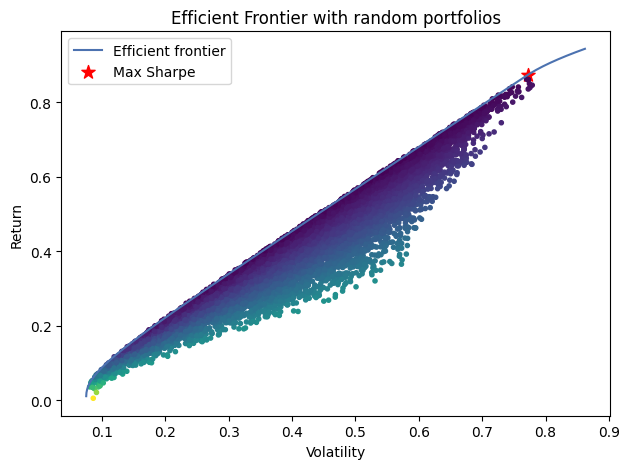

In [ ]:
# Optimize portfolio for maximal Sharpe ratio 
fig, ax = plt.subplots()
ef = EfficientFrontier(mu, S)
pt.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

Again, The maximized Sharpe-Ratio (which is an indication of how well the risk-ajusted performance a portfolio can be) is corresponding to a Portfolio with the following ratios:

In [ ]:
# Optimized Portfolio ratios 

labels = cleaned_weights.keys()
sizes = cleaned_weights.values()

optimized_portfolio = pd.DataFrame([i for i in zip(labels, sizes)], columns=['Tickers','Ratio'])
optimized_portfolio

,Tickers,Ratio
0,BNB-USD,0.6736
1,BTC-USD,0.0000
2,ETH-USD,0.3264
3,USDC-USD,0.0000
4,USDT-USD,0.0000


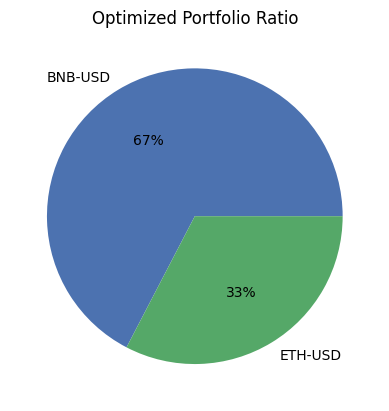

In [ ]:
# Ratios Visualization

# eliminate the zero ratios
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

plt.title('Optimized Portfolio Ratio')
plt.pie(sizes, labels=labels, autopct='%.0f%%')
plt.show()

## Portfolio Perfomance

### Optimized Portfolio

Starting by checking the sum of ratios as they must equal to 1.

In [ ]:
ratios = [i for i in cleaned_weights.values()]

In [ ]:
ratios

[0.6736, 0.0, 0.3264, 0.0, 0.0]

In [ ]:
sum(ratios)

1.0

Then computing the daily returns by calling the pct_change() attribute of pandas library.

In [ ]:
#returns of each currency separatly
returns = data.pct_change()[1:]
returns

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-01-02,-0.048365,-0.029819,-0.025931,0.000934,0.001729
2020-01-03,0.048625,0.051452,0.053069,0.000255,0.002623
2020-01-04,0.016915,0.008955,0.006690,0.004171,0.003266
2020-01-05,0.015802,0.000089,0.008939,-0.000960,-0.001266
2020-01-06,0.060009,0.048291,0.058905,-0.005333,-0.003274
...,...,...,...,...,...
2023-04-26,-0.022179,0.004066,-0.000101,-0.000116,0.000123
2023-04-27,0.001128,0.036981,0.022620,-0.000202,-0.000317
2023-04-28,-0.020214,-0.004530,-0.008526,0.000213,0.000731


In [ ]:
# portfolio returns
portfolio_returns = (ratios * returns).sum(axis=1)
portfolio_returns

Date
2020-01-02   -0.041043
2020-01-03    0.050076
2020-01-04    0.013577
2020-01-05    0.013562
2020-01-06    0.059649
                ...   
2023-04-26   -0.014973
2023-04-27    0.008143
2023-04-28   -0.016399
2023-04-29   -0.002081
2023-04-30    0.026964
Length: 1215, dtype: float64

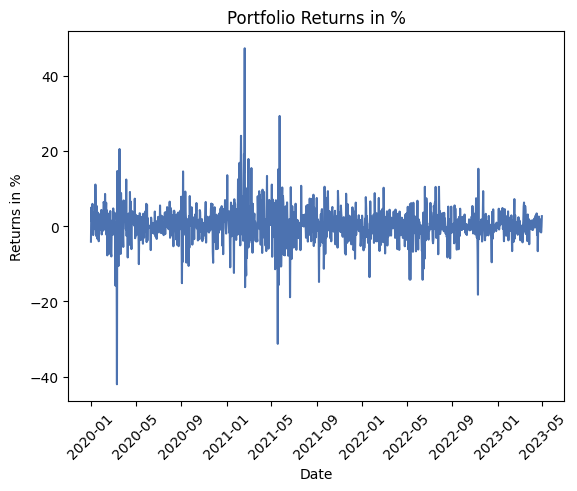

In [ ]:
#Visualizing the returns in %:
sns.lineplot(portfolio_returns*100).set(title= 'Portfolio Returns in %', 
                                    xlabel='Date',
                                    ylabel='Returns in %')
plt.xticks(rotation=45)
plt.show()

In [ ]:
(portfolio_returns*100).describe()

count    1215.000000
mean        0.387272
std         4.917244
min       -42.049079
25%        -1.721881
50%         0.311282
75%         2.614591
max        47.373295
dtype: float64

In [ ]:
portfolio_cum_returns = (1 + portfolio_returns).cumprod() - 1
portfolio_cum_returns

Date
2020-01-02    -0.041043
2020-01-03     0.006978
2020-01-04     0.020650
2020-01-05     0.034492
2020-01-06     0.096198
                ...    
2023-04-26    23.561237
2023-04-27    23.761249
2023-04-28    23.355187
2023-04-29    23.304501
2023-04-30    23.959837
Length: 1215, dtype: float64

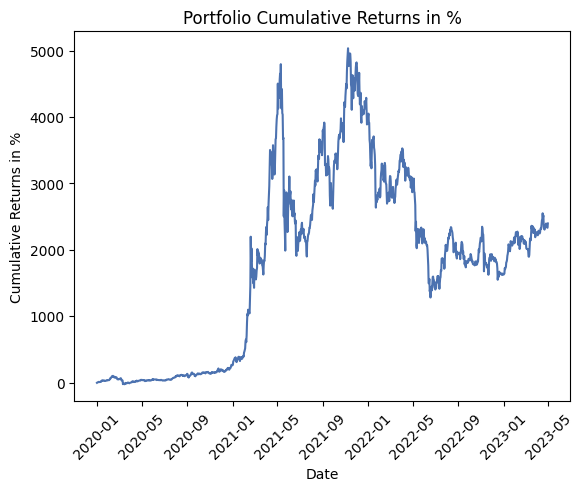

In [ ]:
##Visualizing the returns in %:
sns.lineplot(portfolio_cum_returns*100).set(title= 'Portfolio Cumulative Returns in %',
                                            xlabel='Date',
                                            ylabel='Cumulative Returns in %')
plt.xticks(rotation=45)
plt.show()

### Benchmark Portfolio

For the sake of comparaison, we create a benchmark portfolio consisted of the same currencies but with equivalent ratios.

In [ ]:
# Benchmark portfolio ratios
b_weights = [round(1/len(cc), 2) for i in cc]
b_weights

[0.2, 0.2, 0.2, 0.2, 0.2]

In [ ]:
# Our benchmark portfolio
benchmark_portfolio = data.copy()
benchmark_portfolio

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-01-01,13.689083,7200.174316,130.802002,1.004079,0.999836
2020-01-02,13.027011,6985.470215,127.410179,1.005017,1.001565
2020-01-03,13.660452,7344.884277,134.171707,1.005273,1.004192
2020-01-04,13.891512,7410.656738,135.069366,1.009466,1.007472
2020-01-05,14.111019,7411.317383,136.276779,1.008497,1.006197
...,...,...,...,...,...
2023-04-26,330.821777,28422.701172,1866.564209,0.999884,1.000282
2023-04-27,331.195099,29473.787109,1908.786377,0.999682,0.999965
2023-04-28,324.500244,29340.261719,1892.512817,0.999895,1.000696


Computing the daily returns given the new ratios.

In [ ]:
#Computing returns
benchmark_portfolio_returns = (benchmark_portfolio * b_weights).pct_change()[1:].sum(axis=1)

In [ ]:
benchmark_portfolio_returns

Date
2020-01-02   -0.101452
2020-01-03    0.156023
2020-01-04    0.039997
2020-01-05    0.022604
2020-01-06    0.158599
                ...   
2023-04-26   -0.018207
2023-04-27    0.060210
2023-04-28   -0.032326
2023-04-29   -0.001756
2023-04-30    0.031935
Length: 1215, dtype: float64

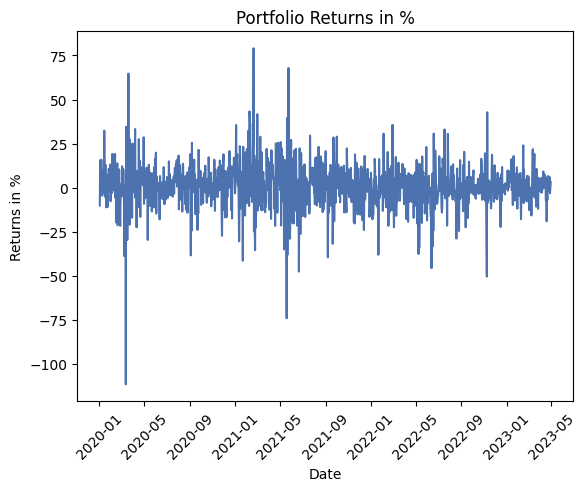

In [ ]:
sns.lineplot(benchmark_portfolio_returns*100).set(title= 'Portfolio Returns in %',
                                                   xlabel='Date',
                                                   ylabel='Returns in %')
plt.xticks(rotation=45)
plt.show()

In [ ]:
benchmark_portfolio_returns.describe()

count    1215.000000
mean        0.009374
std         0.126255
min        -1.116017
25%        -0.048236
50%         0.011394
75%         0.073990
max         0.790947
dtype: float64

In [ ]:
benchmark_portfolio_cum_returns = (1 + benchmark_portfolio_returns).cumprod() - 1

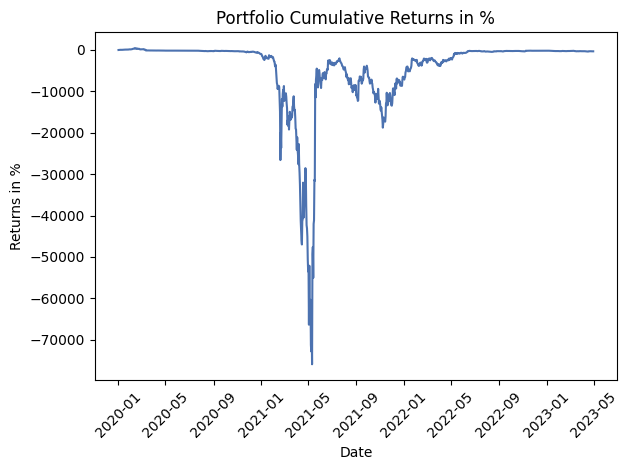

In [ ]:
sns.lineplot(benchmark_portfolio_cum_returns*100).set(title= 'Portfolio Cumulative Returns in %',
                                                       xlabel='Date',
                                                       ylabel='Returns in %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Performance Comparaison

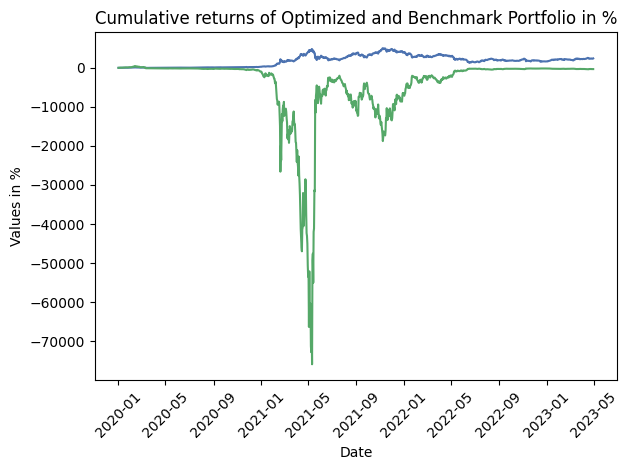

In [ ]:
plt.subplot()
pcr100 = portfolio_cum_returns*100
bprc100 = benchmark_portfolio_cum_returns*100
sns.lineplot(pcr100)
sns.lineplot(bprc100)
plt.title('Cumulative returns of Optimized and Benchmark Portfolio in %')
plt.xlabel('Date')
plt.ylabel('Values in %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Performance with budget
budget = float(input('Input your initial investement: '))

Input your initial investement: 1000


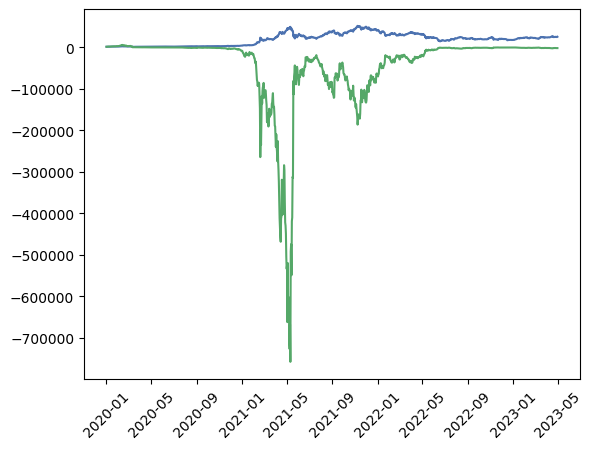

In [ ]:
# Cumulative Returns with budget
plt.subplot()
plt.plot((1+portfolio_cum_returns) * budget)
plt.plot((1+benchmark_portfolio_cum_returns) * budget)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Portfolio value:
rslt_opt = (portfolio_cum_returns[-1]) * budget
rslt_ben = (benchmark_portfolio_cum_returns[-1]) * budget

print(f'With initial budget of USD {round(budget, 2)}, we get a cumulative return of: \n',
      'Optimized Portfolio: USD ', round(rslt_opt, 2), 
      '\n Benchmark Portfolio: USD ',round(rslt_ben, 2))

With initial budget of USD 1000.0, we get a cumulative return of: 
 Optimized Portfolio: USD  23959.84 
 Benchmark Portfolio: USD  -3292.85


# Streamlit App

Wrapping all previous steps into a Streamlit App

In [ ]:
# Template
# https://streamlit-example-app-download-app-lk16x1.streamlit.app/
# https://github.com/damianboh/portfolio_optimization/blob/main/portfolio_optimization_streamlit/app.py

# Design
"""
Title [CryptoPortOpt] AKA Crypto Currencies Porfolio' Optimizer

Step1: Select Your Porfolio
  -> The user will be provider with a list of  10 most popular
  crypto by market cap

Step2:
  -> Optimization Horizon
  From {starting date => default '2020-01-01'} to {ending date => default 'date.time.now()'}

Step3: Budget(Optional)
  ->  Default to 1000 USA for Porfolio Performation visualizations

Step3: Risk Free Market
  -> Try FED, else ==> 3%

Step4: Optimize using MVO/PyPortOpt
  -> Maximize Sharpe Ratio

Step4: Results/Visualisation/Benchmark
  -> Asset Optimized Allocations
  -> Portfolio Performance (Gain/Loss)
"""

In [ ]:
# modules required to run the App
%%writefile requirements.txt
pandas
matplotlib
seaborn
numpy
yfinance
yahooquery
requests
requests_html
datetime
pypfopt

In [ ]:
%%writefile app.py
# modules imports
import streamlit as st
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import yfinance as yf
from yahooquery import Screener
import requests
from requests_html import HTMLSession
from datetime import datetime
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting as pt

# Helper functions


def tickers_list():
    '''
    generate 10 most popular cryto currencies tickers
    '''
    session = HTMLSession()
    num_currencies=10
    resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
    tables = pd.read_html(resp.html.raw_html)               
    df = tables[0].copy()
    cc = df.Symbol.tolist()
    return cc

def get_data(selected_tickers, start_date, end_date):
    '''
    given the selected_tickers, load the corresponding closing price from
    start_date until end_date
    '''
    tickers = yf.Tickers(selected_tickers)
    data = tickers.history(start=start_date,end=end_date,interval='1d')['Close']
    return data

def fed_rate():
    '''
    Loading the US federal reserve interest rate
    and set type as float.
    '''
    # Scrapping the current FED interest rate:
    all_data = pd.read_html('https://www.global-rates.com/en/interest-rates/central-banks/central-bank-america/fed-interest-rate.aspx')
    FED = [df for df in all_data if df.iloc[0][0] == 'American interest rate (Fed)'][0].iloc[0][1]
    # Formating into float
    return float(FED[:5])/100

def optimized_ratios(data, start_date, end_date, safe):
    '''
    Compute the optimized ratios of selected tickers given:
     - start and end date time-horizon.
     - Risk free interest rate as Safe parameter.
    Return the result as pandas data frame
    '''
    mu = mean_historical_return(data)
    S = CovarianceShrinkage(data).ledoit_wolf()
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe(risk_free_rate= safe)
    cleaned_weights = ef.clean_weights()
    # optimized_portfolio = pd.DataFrame([i for i in zip(cleaned_weights.keys(), 
    #                                                    cleaned_weights.values())], 
    #                                                    columns=['Tickers','Ratio'])
    # return optimized_portfolio
    return [round(i, 2) for i in cleaned_weights.values()]

def benchmark_ratios(selected_tickers):
     '''
     Alternative portfolio ratio with equal share of
     the selected tickers.
     Used for performance comparaison.
     Return the results as a pandas data frame
     '''
     return pd.DataFrame([i for i in zip(selected_tickers,
                                         [(1/len(selected_tickers)) for i in (selected_tickers)])])
## Optimized Ratios pieplot
def pie_plot(data):
    '''
    Pie Plot of the optimized ratios of selected tickers
    '''
    pie_fig = alt.Chart(data).mark_arc().encode(
         theta=alt.Theta(field="Ratio", type="quantitative"),
         radius=alt.Radius('Ratio', 
                           scale=alt.Scale(type="sqrt", 
                                           zero=True, 
                                           rangeMin=20)),
         color=alt.Color(field="Tickers", type="nominal"))
    return pie_fig

## func lineplot daily&cumul_daily returns in %
# > with logaritmic scaling.
# def plot_ret(returns, type):
#     '''
#     Plot the line plot of calculated portfolio returns
#     '''
#     axis_scale = 'linear'
#     if st.checkbox("View logarithmic scale"):
#         axis_scale = "log"

#     return alt.Chart(returns).mark_line().encode(
#         x=alt.X(''),
#         color=alt.Color(field='', type='nominal')).interactive()


# Benchmark Section
## Cumulative Revenus Comparaison plot in %
# '''
# func generate 
#     - cumul_daily return for equi_ratio_portfolio
#     - func lineplot cumul_daily return for optimized_port vs equi_ratio_portfolio
# '''
## Cumulative Revenues Comparaison to end_date
def h_bar(opt_rslts, ben_rslts):
    '''
     Plot a horizontal bar plot of the investement cumulative gain/loss
     of optimized and benchmark porfolio.
    '''
    bar = pd.DataFrame(zip([opt_rslts, ben_rslts],['Optimized', 'Benchmark']), 
                        columns=['Investements Results','Scenarios'])
    return alt.Chart(bar).mark_bar().encode(
        x='Investements Results:Q',
        y='Scenarios:O',
        color=alt.Color(field="Scenarios", type="nominal")
    )

def app_exec():

    #Application Title
    st.set_page_config(page_title = "Crypto Fire")
    st.title("Crypto-Currency Portfolio Optimizer")

    #Sub_Title_1 # Portfolio Main Parameters
    st.header('Configure your portfolio')
    # Pick The Starting/End Date 
    st.markdown('Define the Optimization time horizon') 
    col1, col2 = st.columns(2)

    with col1:
	    start_date = st.date_input("Start Date",datetime(2020, 1, 1))
	
    with col2:
        end_date = st.date_input("End Date") # with current date as default

    # Selecting Assets
    tickers= tickers_list()
    selected_tickers = st.multiselect("Pick your preferred crypto-currencies ",
                                     tickers,
                                     default=tickers[:2]
                                    )
    
    # Set the Risk Free Rate
    try:
         safe = fed_rate()
    except:
         safe = 0.03
    
    risk_free_rate = st.number_input('Define the Risk Free Rate',
                                     min_value= 0.00,
                                     max_value= None,
                                     value= fed_rate())

    # Initial Investement
    initial_invest = st.number_input('What is your initial investement? (USD)',
                                     min_value= 1.00,
                                     max_value= None,
                                     value= 1000.00)
    
    # Backend variables
    data = get_data(selected_tickers, start_date, end_date)
    returns = data.pct_change()[1:]
    opt_ratio = optimized_ratios(data, start_date, end_date, safe)
    opt_d_ret = (opt_ratio * returns).sum(axis= 1)
    opt_c_ret = (1+ opt_d_ret).cumprod()
    ben_ratio = [(1/len(selected_tickers)) for i in selected_tickers]
    ben_d_ret = (ben_ratio * returns).sum(axis= 1)
    ben_c_ret = (1+ ben_d_ret).cumprod()
    opt_rslts = round(opt_c_ret[-1] * initial_invest, 2)
    ben_rslts = round(ben_c_ret[-1] * initial_invest, 2)

    # Sub_Title_2 # Optimization Results
    if st.button('Optimus Cryptus! :fire:'):
        st.header('Optimization Results')
        source = pd.DataFrame(zip(selected_tickers, opt_ratio),
                              columns=['Tickers', 'Ratio'])
        
        st.markdown('Optimized Ratios')
        st.altair_chart(pie_plot(source),
                        theme = 'streamlit',
                        use_container_width=True)
        
        st.markdown('Optimized Returns')
        tab1, tab2 = st.tabs(['Daily Returns in %',
                              'Cumulative Daily Returns in %'])
        # with tab1:
        #      st.altair_chart(plot_ret(opt_d_ret), 
        #      theme='streamlit',
        #      use_container_width= True)
        # with tab2:
        #      st.altair_chart(plot_ret(opt_c_ret),
        #                       theme='streamlit', 
        #                       use_container_width= True)
        st.markdown('Compare Returns with Benchmark Portfolio')

        st.markdown(f'Total Gain/Loss for each Portfolio given intial investement of {initial_invest} USD')
        st.altair_chart(h_bar(opt_rslts, ben_rslts),
                       theme='streamlit',
                       use_container_width=True)

app_exec()

# Conclusion

Beyond the App
- Portfolio builder App

# References
[Getting Crypto Symbols](https://stackoverflow.com/a/74656748)

[Portfolio Optimization Using Python](https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb)

[Portfolio Builder](https://github.com/yeungadrian/PortfolioBuilder)

[Portfolio Selection with Graph Algorithms and Deep Learning](https://www.linkedin.com/pulse/portfolio-selection-graph-algorithms-deep-learning-maya-benowitz)

[G-Research Crypto Forecasting](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview)

[G-Research Crypto Forecasting](https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook#Preprocessing)

[yfinance guide](https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance
)

[Portfolio Optimization with PyPortfolioOpt](https://github.com/paulsg3/PortfolioOptimization/blob/main/Portfolio_Optimization.ipynb)

[PyPortfolioOpt Documentation](https://pyportfolioopt.readthedocs.io/en/latest/)

[Portfolio Optimization using Reinforcement Learning](https://github.com/kvsnoufal/portfolio-optimization)

[Multi-level Columns](https://stackoverflow.com/a/56080234)

[On the non-stationarity of financial time series: Impact on optimal portfolio selection](https://www.researchgate.net/publication/224905259_On_the_non-stationarity_of_financial_time_series_Impact_on_optimal_portfolio_selection)

[Stationary TS](https://analyticsindiamag.com/how-to-make-a-time-series-stationary/)

[Volatility Analysis](https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/)

[Volatility Analysis](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/)

[Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp)

[Mean-variance Optimization](https://www.investopedia.com/terms/m/meanvariance-analysis.asp)

[Backtesting](https://gist.github.com/jatinkathiriya/ca9063711316d9b7c3cbd993b8c6656b#file-portfolio-backtesting-ipynb)

[PyPortOpt with Stock](https://github.com/damianboh/portfolio_optimization/blob/main/Max%20Sharpe%20Ratio%20Portfolio%20Optimization%20for%20Stocks%20Using%20PyPortfolioOpt.ipynb)